In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

import seaborn as sns
%matplotlib inline

In [2]:
## Vamos a la base y se crea (en principio sin oversampling)
df = pd.read_csv('base.csv')
df.drop(['Unnamed: 0','spotifyID'], axis=1, inplace = True)
y = df['hit']
X = df.drop(['hit'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

### Sin SMOTE

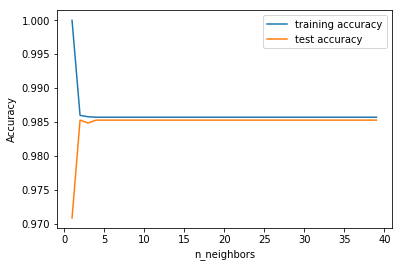

In [34]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 40)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.savefig('knn_compare_model')

In [36]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 0.99


In [5]:
y_pred = knn.predict(X_test)
roc_auc_score(y_test,y_pred)

0.5

In [6]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      7026
          1       0.00      0.00      0.00       105

avg / total       0.97      0.99      0.98      7131



/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [7]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[7026    0]
 [ 105    0]]


### SMOTE

La influencia que posee el desbalanceo es importante. Se repetirá el análisis con Oversampling

In [8]:
sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

knn.fit(X_train_res,y_train_res)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [9]:
y_pred = knn.predict(X_test)
roc_auc_score(y_test,y_pred)

0.5591476556463747

In [10]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.99      0.69      0.81      7026
          1       0.02      0.43      0.04       105

avg / total       0.97      0.69      0.80      7131



In [11]:
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[4846 2180]
 [  60   45]]


### Curvas `ROC` y área bajo la curva (`AUC`)

In [12]:
y_probs_knn = knn.predict_proba(X_test)
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_probs_knn[:,1])

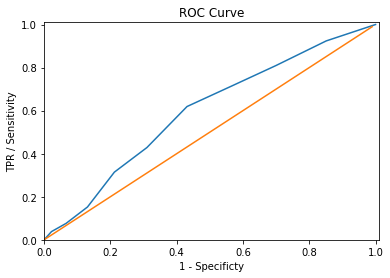

In [13]:
df = pd.DataFrame(dict(fpr=fpr_knn, tpr=tpr_knn, thr = thr_knn))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

#### Area bajo la curva ROC

In [14]:
print('AUC=', auc(fpr_knn, tpr_knn))

AUC= 0.5952462282949047


Sobre la base del area bajo la curva ROC se puede decir que el modelo es **malo** dado que se encuentra entre [0.5, 0.6).

### `GridSearch` con knn y SMOTE

In [15]:
k_range = list(range(1, 31))
knn = KNeighborsClassifier(n_neighbors=8)

In [16]:
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [17]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_res, y_train_res)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [18]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [19]:
pd.DataFrame(grid.cv_results_).columns

/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/py

Index(['mean_fit_time', 'mean_score_time', 'mean_test_score',
       'mean_train_score', 'param_n_neighbors', 'params', 'rank_test_score',
       'split0_test_score', 'split0_train_score', 'split1_test_score',
       'split1_train_score', 'split2_test_score', 'split2_train_score',
       'split3_test_score', 'split3_train_score', 'split4_test_score',
       'split4_train_score', 'split5_test_score', 'split5_train_score',
       'split6_test_score', 'split6_train_score', 'split7_test_score',
       'split7_train_score', 'split8_test_score', 'split8_train_score',
       'split9_test_score', 'split9_train_score', 'std_fit_time',
       'std_score_time', 'std_test_score', 'std_train_score'],
      dtype='object')

In [20]:
pd.DataFrame(grid.cv_results_)

/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/chango/anaconda3/lib/py

mean_fit_time  mean_score_time  mean_test_score  mean_train_score  \
0        0.034929         0.013451         0.735372          1.000000   
1        0.046967         0.018212         0.726368          0.894479   
2        0.041439         0.016530         0.730187          0.854316   
3        0.041433         0.018101         0.729066          0.832146   
4        0.034858         0.015607         0.726263          0.812288   
5        0.045562         0.020213         0.727594          0.802210   
6        0.034277         0.016084         0.724511          0.790266   
7        0.034147         0.017130         0.725282          0.785217   
8        0.033997         0.016919         0.725002          0.777182   
9        0.034382         0.017912         0.725352          0.774621   
10       0.034486         0.018238         0.721708          0.768404   
11       0.034348         0.018451         0.722164          0.766294   
12       0.034485         0.018930         0.721358          0.761140   
13       0.034074         0.018903         0.721568          0.760139   
14       0.034609         0.019685         0.718800          0.756616   
15       0.033911         0.019578         0.720482          0.755211   
16       0.034032         0.020046         0.719466          0.751462   
17       0.033854         0.020074         0.718590          0.751084   
18       0.033802         0.020691         0.719922          0.748639   
19       0.035205         0.021911         0.721253          0.748274   
20       0.034076         0.021695         0.718450          0.745661   
21       0.034265         0.021885         0.719466          0.745510   
22       0.035119         0.023117         0.719046          0.742987   
23       0.035142         0.022898         0.719781          0.742617   
24       0.034851         0.023571         0.719922          0.740873   
25       0.034870         0.024403         0.719431          0.740811   
26       0.034620         0.024719         0.719676          0.739585   
27       0.034976         0.025320         0.719431          0.739207   
28       0.034586         0.025655         0.719501          0.738195   
29       0.034919         0.025872         0.720867          0.738226   

   param_n_neighbors               params  rank_test_score  split0_test_score  \
0                  1   {'n_neighbors': 1}                1           0.746499   
1                  2   {'n_neighbors': 2}                5           0.734594   
2                  3   {'n_neighbors': 3}                2           0.741947   
3                  4   {'n_neighbors': 4}                3           0.745448   
4                  5   {'n_neighbors': 5}                6           0.733894   
5                  6   {'n_neighbors': 6}                4           0.740896   
6                  7   {'n_neighbors': 7}               10           0.733894   
7                  8   {'n_neighbors': 8}                8           0.739496   
8                  9   {'n_neighbors': 9}                9           0.742297   
9                 10  {'n_neighbors': 10}                7           0.740896   
10                11  {'n_neighbors': 11}               12           0.735644   
11                12  {'n_neighbors': 12}               11           0.732843   
12                13  {'n_neighbors': 13}               14           0.732843   
13                14  {'n_neighbors': 14}               13           0.735644   
14                15  {'n_neighbors': 15}               28           0.730042   
15                16  {'n_neighbors': 16}               17           0.732493   
16                17  {'n_neighbors': 17}               23           0.732143   
17                18  {'n_neighbors': 18}               29           0.724090   
18                19  {'n_neighbors': 19}               18           0.728641   
19                20  {'n_neighbors': 20}               15           0.730742   
20                21  {'n_neighbors': 2

In [21]:
grid.best_estimator_, grid.best_score_, grid.best_params_

(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='uniform'), 0.7353724336066149, {'n_neighbors': 1})

In [26]:
k_range = list(range(1, 51))
weight_options = ['uniform', 'distance']

param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50], 'weights': ['uniform', 'distance']}


In [27]:
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_res, y_train_res)

print (grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=31, p=2,
           weights='distance')
0.7458131875832107
{'n_neighbors': 31, 'weights': 'distance'}


In [28]:
knn = KNeighborsClassifier(n_neighbors=31, weights='uniform')
knn.fit(X_train_res, y_train_res)
y_pred = knn.predict(X_test)

In [29]:
print (classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      0.69      0.82      7026
          1       0.02      0.50      0.05       105

avg / total       0.98      0.69      0.80      7131
 [[4870 2156]
 [  52   53]]


### Curvas `ROC` y área bajo la curva (`AUC`)

In [30]:
y_probs_knn = knn.predict_proba(X_test)
fpr_knn,tpr_knn,thr_knn = roc_curve(y_test, y_probs_knn[:,1])

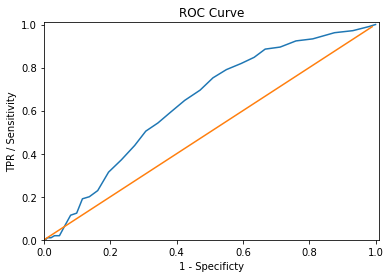

In [31]:
df = pd.DataFrame(dict(fpr=fpr_knn, tpr=tpr_knn, thr = thr_knn))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

#### Area bajo la curva ROC

In [32]:
print('AUC=', auc(fpr_knn, tpr_knn))

AUC= 0.6403318287178236


Sobre la base del area bajo la curva ROC se puede decir que el modelo es **regular** dado que se encuentra entre [0.6, 0.75).